In [125]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import h5py
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import weight_norm
import os

### 1. load pre-preocessed dataset

###### 1 nor_sta_fes,dys,ys are static, dynamic and slow-moving landslide deformtion,respectively
###### 2 All these three datasets are model's inputs with pre-processing, including  Missing value padding, normalization.
###### 3 nor_sta_fes is a two-dimension dataset with size of [landslide_numbers, static_variables]
###### 4 deformtion is a two-dimension dataset with size of [time_steps, landslide_numbers]
###### 5 dys is a four-dimension dataset with size of [time_steps,dynamic_variable_numbers, look_backs, landslide_numbers]

In [126]:
nor_sta_fes = torch.from_numpy(pd.read_csv('./data/nor_static_fe.csv').to_numpy().astype('float32'))
dys= torch.from_numpy(np.load('./data/nor_dys.npy').astype('float32'))
ys = torch.from_numpy(pd.read_csv('./data/nor_smoothed_deform_.csv').T.to_numpy().astype('float32'))

print(nor_sta_fes.shape,dys.shape,ys.shape)

torch.Size([78, 11]) torch.Size([83, 8, 90, 78]) torch.Size([83, 78])


In [129]:
### Divide the training, validation and testing stes based on the length of the time series
x_train = dys[:68]
x_val = dys[68:76]
x_test = dys[76:]

y_train = ys[:68]
y_val = ys[68:76]
y_test = ys[76:]
    
device = torch.device("cuda:0")
#device = torch.device("cpu")
nor_sta_fes = nor_sta_fes.to(device)
x_train = x_train.to(device)
x_val = x_val.to(device)
x_test = x_test.to(device)

### 2. Define a TCN model

In [80]:
class OutputLayerWithAttention(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayerWithAttention, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)

        # Transformer-Style Attention
        self.attention = nn.MultiheadAttention(embed_dim=c, num_heads=4, batch_first=True)

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  # [batch_size, channels, height, width]
        x_t1 = self.drop3(x_t1)

        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)  # Layer normalization

        # Attention applied to the last two dimensions
        batch, channels, height, width = x_ln.size()
        x_reshaped = x_ln.view(batch, channels, -1).permute(0, 2, 1)  # [batch, seq_len, channels]
        attn_output, _ = self.attention(x_reshaped, x_reshaped, x_reshaped)  # Apply attention
        x_t2 = attn_output.permute(0, 2, 1).view(batch, channels, height, width)

        x_t2 = self.relu4(self.tconv2(x_t2))
        x_t2 = self.drop4(x_t2)

        return self.fc(x_t2)

In [127]:
class Chomp2d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp2d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        裁剪的模块，裁剪多出来的padding
        """
        return x[:, :, :-self.chomp_size[0], :-self.chomp_size[1]].contiguous()
    
class FullyConvLayer(nn.Module):
    def __init__(self, c):
        super(FullyConvLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)
        self.fc = FullyConvLayer(c)
        
        

    def forward(self, x):
        x_t1 = self.relu3(self.tconv1(x))  
        #print(x_t1.shape)
        x_t1 = self.drop3(x_t1)
        
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.relu4(self.tconv2(x_ln))
        x_t2 = self.drop4(x_t2) #same size with x_ln

        return self.fc(x_t2)    



class TN_module(nn.Module):
    def __init__(self, sta_in,c_in, c_out,num_lands, dropout, dia=1):
        super(TN_module, self).__init__()
        
        self.conv1 = weight_norm(nn.Conv2d(c_in, c_out, (3,1),
                                           stride=1, padding=(0,0), dilation=dia))
        # 经过conv1，输出的size其实是(Batch, input_channel, seq_len + padding)
        self.dropout1 = nn.Dropout(dropout)
        self.chomp1 = Chomp2d((2,0))  
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=2, padding=(0, 0)
        ) 
        self.dropout2 = nn.Dropout(dropout)
        self.relu2 = nn.ReLU()
        
        self.conv3 = nn.Conv2d(
            c_out, c_out, (3, 1), 1, dilation=4, padding=(0, 0)
        )
                
        self.dropout3 = nn.Dropout(dropout)
        self.relu3 = nn.ReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1,
                                 self.conv2,self.relu2, self.dropout2,
                                self.conv3,self.relu3, self.dropout3,)
        self.init_weights()
        
        self.fc1 = nn.Linear(sta_in,28)  #28 hidden layer for static_fes
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(dropout)
        self.out = OutputLayer(28+c_out, 76, num_lands)  ######## the last dimension is equal to the number of landslide numbers
        #self.out = OutputLayerWithAttention(24+c_out, 76, 83)  #this is a alternative layer with attention module
        
    
    def init_weights(self):
        """
        参数初始化
        """
        self.conv1.weight.data.normal_(0, 0.01)
    
    def forward(self, x1,x2):
        
        x1 = self.net(x1)  
        x2 = self.relu(self.fc1(x2))
        x2 = self.drop1(x2).T
        
        x2 = x2.unsqueeze(0)
        x2 = x2.unsqueeze(2)
        x2 = x2.repeat(x1.shape[0],1,x1.shape[2],1)
        #print(x2.shape)
        out = torch.cat((x1, x2), dim=1)
        #print(out.shape)
        # Output layer
        out = self.out(out).squeeze(1)
        
        return out.squeeze(1)
    

def torch_corre(y_pre,y_true):
    y_pre = y_pre.view((-1,))
    y_true = y_true.view((-1,))
    #print(y_pre.shape,y_true.shape)
    stacked = torch.stack((y_true, y_pre))
    
    # 计算相关系数矩阵
    corr_matrix = torch.corrcoef(stacked)
    # 提取皮尔逊相关系数
    pearson_coefficient = corr_matrix[0, 1]
    return pearson_coefficient

In [91]:
class WMSE_loss(nn.Module):
    def __init__(self):
        super(WMSE_loss,self).__init__()
    def forward(self,y_pred,y_true):
        
        mean_w = torch.mean(y_true)
        error = torch.mean(abs(y_true)*(y_true - y_pred)**2/mean_w)
        return error

### 3. Model Training

In [124]:
batch_size = 10
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
tmp_pcc = 0.71
    
    
### sta_in = static_variables
### c_in = dynamic_variables, c_out is hidden layer nueral number for dynamic
### num_lands = number of landslides in your datastet
    
tcn = TN_module(sta_in = 11, c_in = 8, c_out = 64,num_lands = 78, dropout = 0.5).to(device)
for j in range(20):
        
    optimizer = torch.optim.Adam(tcn.parameters(), lr=0.002*0.9**j,weight_decay = 5e-5)
    if j<15:
        loss = nn.MSELoss()
    else:
        loss = WMSE_loss()
    for epoch in range(1, 20+1):
        l_sum, n = 0.0, 0
        tcn.train()
        for x, y in train_iter:
            x, y= x.to(device), y.to(device)
            y_pred = tcn(x,nor_sta_fes)
            l = loss(y_pred, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.item() * y.shape[0]
            n += y.shape[0]
        #scheduler.step()

        tcn.eval()
        val_pre = tcn(x_val,nor_sta_fes).cpu()

        val_loss = torch_corre(val_pre,y_val)
        val_mae = torch.mean(abs(val_pre-y_val))
        if val_loss>tmp_pcc and l_sum/n<0.01 or val_mae<0.11:
            tmp_pcc = val_loss+0.001
            print('----------------------------',val_loss,val_pre.mean())
            model_path = f'./results/attention/dy11_EWM_TCN_{val_loss:.4f}.pth'  # 将验证集损失加入文件名
            torch.save(tcn.state_dict(),model_path)

        if epoch%20 ==1:
            print(" train loss:",l_sum / n,"PCC:",val_loss.item(),val_mae.item())

 train loss: 0.30578925504403953 PCC: 0.31726184487342834 0.2214050590991974
 train loss: 0.04513388072304866 PCC: 0.6312842965126038 0.37429025769233704
 train loss: 0.029015360893133807 PCC: 0.6522728800773621 0.31730642914772034
 train loss: 0.027122062685735086 PCC: 0.6253425478935242 0.20241379737854004
 train loss: 0.02435973922119421 PCC: 0.5834777355194092 0.17308777570724487
 train loss: 0.02173282830592464 PCC: 0.644944965839386 0.2053227573633194
 train loss: 0.017608295989168042 PCC: 0.6823603510856628 0.1659260094165802
 train loss: 0.014611499000559835 PCC: 0.6805263161659241 0.15844355523586273
 train loss: 0.012214487884193659 PCC: 0.7233557105064392 0.1410503089427948
 train loss: 0.011021989014218836 PCC: 0.709213137626648 0.15349385142326355
---------------------------- tensor(0.7185, grad_fn=<SelectBackward0>) tensor(1.0405, grad_fn=<MeanBackward0>)
 train loss: 0.010152233353651622 PCC: 0.6949359774589539 0.12198932468891144
---------------------------- tensor(0.72

### 3. View results

In [122]:
## load trained model
#model_pth = './results/attention/dy11_EWM_TCN_0.7209.pth'
#tcn.load_state_dict(torch.load(model_pth))
tcn.eval()
dys = dys.to(device)
re_y_pre = tcn(dys,nor_sta_fes).cpu().detach().numpy()
re_y_real = ys.numpy()

In [123]:
yr = re_y_pre[-13:,:].reshape(-1,)
yp = re_y_real[-13:,:].reshape(-1,)

np.corrcoef(yr, yp)[0, 1]

0.6806488302050856

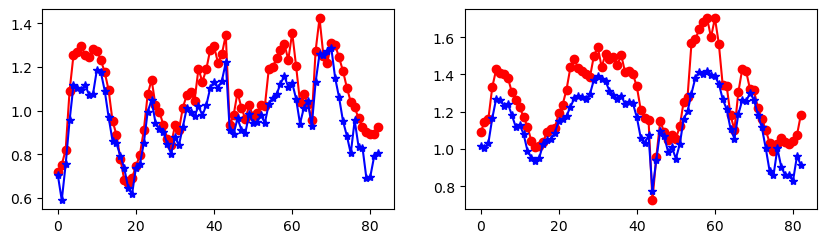

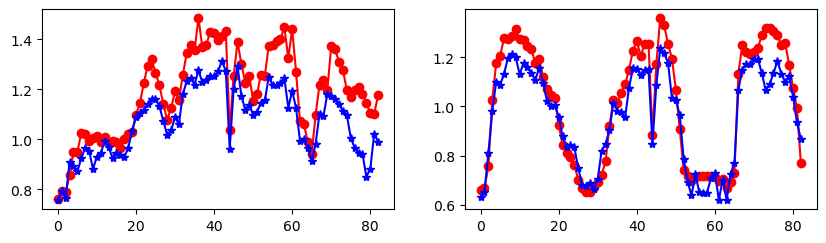

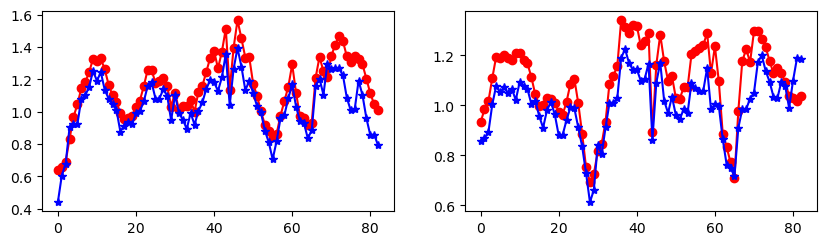

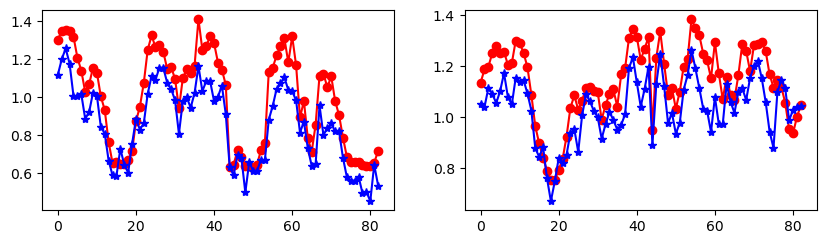

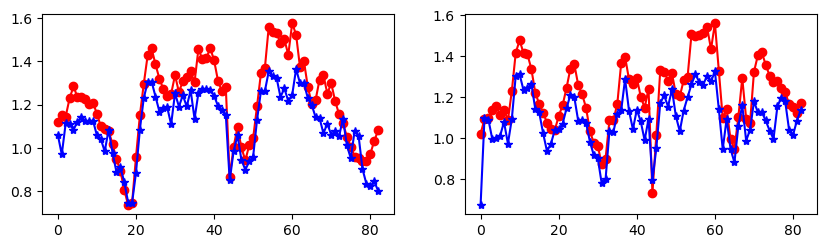

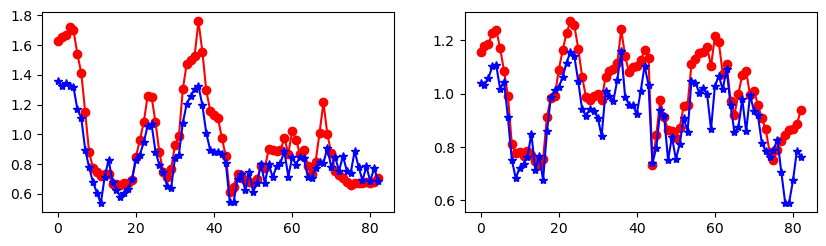

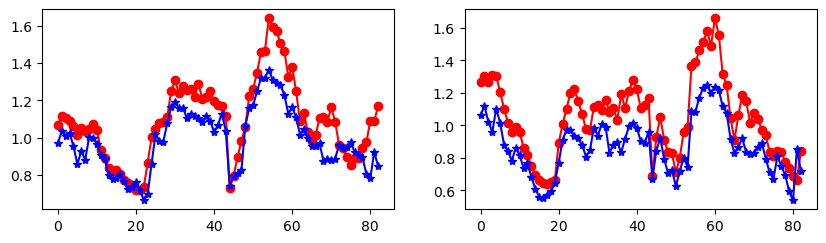

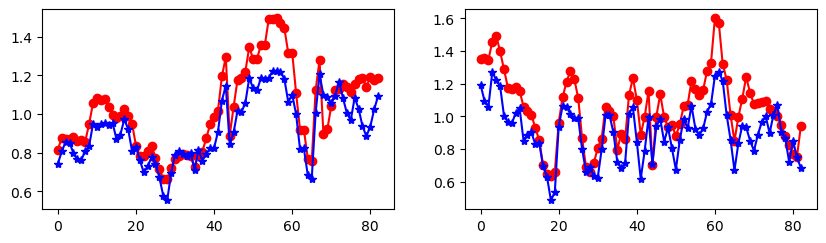

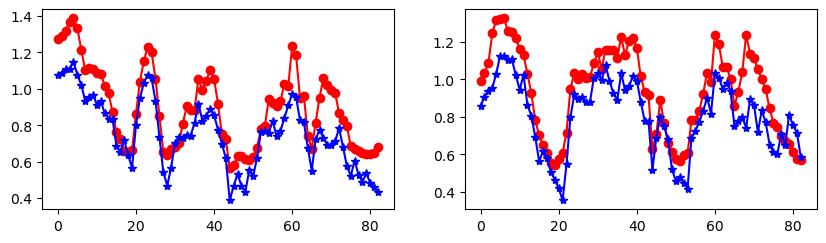

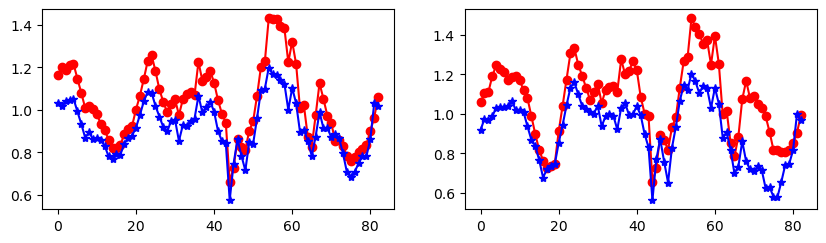

In [117]:
import matplotlib.pyplot as plt
#print(re_y_pre.T)
x= range(re_y_pre.shape[0])
for i in range(10):
    # 创建图形和子图
    fig, axs = plt.subplots(1, 2, figsize=(10, 2.6))  # 1行2列的子图布局

    axs[0].plot(x, re_y_pre[:,2*i],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[0].plot(x, re_y_real[:,2*i],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    axs[1].plot(x, re_y_pre[:,2*i+1],marker='o', linestyle='-', color='r')  # 使用红色线和圆形标记点
    axs[1].plot(x, re_y_real[:,2*i+1],marker='*', linestyle='-', color='b')  # 使用红色线和圆形标记点
    
    #plt.plot(x, x_train[:,1,-1,1234].cpu().detach().numpy(),marker='o', linestyle='-', color='y')  # 使用红色线和圆形标记点
    plt.show()